In [ ]:
%load_ext autoreload
%autoreload 2

: 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from multiprocessing import *
import os
from matplotlib.ticker import StrMethodFormatter
import scipy
from pathos.multiprocessing import ProcessingPool as Pool

import sys
from IPython.display import clear_output

import DarkNews
from DarkNews import const 
from DarkNews.GenLauncher import GenLauncher
from fastbnb import fit_functions as ff
from fastbnb import hist_plot
from fastbnb import analysis
from fastbnb import decayer

ModuleNotFoundError: No module named 'analysis_dn'

# 1. Set general parameters for fitting

### Path and Grid

In [15]:
# PATH
path = 'results/3p1_couplings_e_8e-4/'



# Number of processors
workers = 8

# Grid parameters
points = 150

mzprimearray = [0.03,0.2,0.8,1]


path_data = path+f'chi2_fit_3p1_couplings.dat'
path_data_sbn = path+f'chi2_fit_3p1_couplings_sbn_b.dat'

m4=ff.round_sig(np.geomspace(0.01, 2.0, points),4)

### Parameters for simulation

In [16]:
ud4_def = 1.0/np.sqrt(2.)
gD_def = 2.
umu4_def = np.sqrt(1.0e-12)

v4i_def = gD_def * ud4_def * umu4_def
vmu4_def = gD_def * ud4_def * ud4_def * umu4_def / np.sqrt(1-umu4_def**2)
epsilon_def = 8e-4
epsilon = 8e-4

r_eps = epsilon / epsilon_def

vmu4_f = lambda umu4 : gD_def * ud4_def * ud4_def * umu4 / np.sqrt(1-umu4**2)
v4i_f = lambda umu4 : gD_def * ud4_def * umu4

v_cut = 1e-3

In [17]:
umu4 = np.geomspace(1e-2,5e-1,200)
#umu4 = np.geomspace(v_cut,0.5e-2,100)
vmu4 = vmu4_f(umu4)
v4i = v4i_f(umu4)
n = len(umu4)

# 2. Plots

In [18]:
from matplotlib import cm
import matplotlib.patches as mpatches
from matplotlib import ticker

## Dirac, 3+1

### Enu, $m_{Z'}$ = 1 GeV

In [37]:
mzcase = 3
mzprime = mzprimearray[mzcase]
mzprime = 1.0

coup_factor = 1e3

data_enu = pd.read_csv(path_data,sep='\t',dtype=float)
data_enu = data_enu[(data_enu.mzprime == mzprime)]

data_enu_sbn = pd.read_csv(path_data_sbn,sep='\t')
data_enu_sbn = data_enu_sbn[(data_enu_sbn.mzprime == mzprime)]

plot_path_jpg = path +f'plots/fit_3p1_couplings_mz_{mzprime}_sbn.jpg'
plot_path_pdf = path +f'plots/fit_3p1_couplings_mz_{mzprime}_sbn.pdf'

viridis = cm.get_cmap('viridis', 12)
bar_1 = mpatches.Patch(color=viridis(range(12))[1], label=r'1 $\sigma$')
bar_2 = mpatches.Patch(color=viridis(range(12))[4], label=r'2 $\sigma$')
bar_3 = mpatches.Patch(color=viridis(range(12))[8], label=r'3 $\sigma$')

levels = [0,2.3,6.18,11.83]
chi2_min_enu = data_enu.chi2.min()
min_enu = data_enu[data_enu.chi2 == chi2_min_enu]
xmin_enu, ymin_enu = min_enu['m4'].values, min_enu['v_mu4'].values
ymin_enu *= ymin_enu * coup_factor

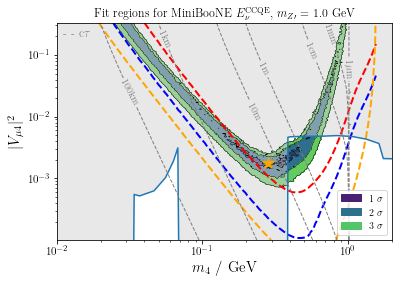

<Figure size 432x288 with 0 Axes>

In [41]:
icarus_factor = (47./60.)**2

m4_in_MeV, UmuNSQR = np.load("Umu4_inv.npy")
m4_lim = m4_in_MeV/1000.
UmuNSQR = np.sqrt(UmuNSQR)

data_enu = data_enu[data_enu.chi2>0]

X = data_enu.m4.values
Y = data_enu.v_mu4.values
Y = Y * Y * coup_factor
Z = (data_enu.chi2.values - chi2_min_enu)
W = data_enu.decay_length.values

X2 = data_enu_sbn.m4.values
Y2 = vmu4_f(data_enu_sbn.u_mu4.values)
Y2 = Y2 * Y2 * coup_factor
Z_mub = data_enu_sbn.n_muB.values
Z_icarus = data_enu_sbn.n_icarus.values * icarus_factor
Z_sbnd = data_enu_sbn.n_sbnd.values

mask_lim = (UmuNSQR < 1./np.sqrt(2))
m4_lim = m4_lim[mask_lim]
UmuNSQR = UmuNSQR[mask_lim]
vmu4_lim = vmu4_f(UmuNSQR) * vmu4_f(UmuNSQR) * coup_factor

xlabel = r'$m_4 \ /$ GeV'
ylabel = r'$|V_{\mu 4}|^2$'
marker1 = '*'

plt.rcParams["figure.figsize"] = (6,4)

cs = plt.tricontourf(X,Y,Z,levels=levels,cmap='viridis')
cs2 = plt.tricontour(X,Y,Z,levels=levels,colors='black',linewidths=0.5)
cs3 = plt.tricontour(X2,Y2,Z_mub,levels=[1000],colors='red',linewidths=2.0, linestyles='dashed')
cs4 = plt.tricontour(X2,Y2,Z_icarus,levels=[1000],colors='blue',linewidths=2.0, linestyles='dashed')
cs5 = plt.tricontour(X2,Y2,Z_sbnd,levels=[1000],colors='orange',linewidths=2.0, linestyles='dashed')

for c in cs.collections:
    c.set_rasterized(True)
for c in cs2.collections:
    c.set_rasterized(True)
for c in cs3.collections:
    c.set_rasterized(True)
for c in cs4.collections:
    c.set_rasterized(True)
for c in cs5.collections:
    c.set_rasterized(True)

limits = plt.plot(m4_lim, vmu4_lim, label=fr"model-independent limits")
plt.fill_between(m4_lim, vmu4_lim, np.ones(np.size(m4_lim))*coup_factor, fc='lightgrey', ec='None', lw =0.0, alpha=0.5)

dec_levels_0 = [0.0001,0.1,1,100,1000,100000,10000000]
dict_lev_0 = {0.0001: r'1$\mu$m',0.1:r'1mm',1: r'1cm',100: r'1m',1000: r'10m',100000:r'1km',10000000:r'100km'}


dec_levels = [0.0001,0.1,1,100,1000,100000,10000000]
dict_lev = {0.0001: r'1$\mu$m',0.1:r'1mm',1: r'1cm',100: r'1m',1000: r'10m',100000:r'1km',10000000:r'100km'}


pos = 7
posb = 1
posc = 1
decay = plt.tricontour(X,Y,W,levels=[dec_levels[0]],colors='gray',linewidths=1.0,linestyles='dashed')
decay2 = plt.tricontour(X,Y,W,levels=[dec_levels[1]],colors='gray',linewidths=1.0,linestyles='dashed')
decay3 = plt.tricontour(X,Y,W,levels=[dec_levels[2]],colors='gray',linewidths=1.0,linestyles='dashed')
decay4 = plt.tricontour(X,Y,W,levels=[dec_levels[3]],colors='gray',linewidths=1.0,linestyles='dashed')
decay5 = plt.tricontour(X,Y,W,levels=[dec_levels[4]],colors='gray',linewidths=1.0,linestyles='dashed')
decay6 = plt.tricontour(X,Y,W,levels=[dec_levels[5]],colors='gray',linewidths=1.0,linestyles='dashed')
decay7 = plt.tricontour(X,Y,W,levels=[dec_levels[6]],colors='gray',linewidths=1.0,linestyles='dashed')

plt.text(0.011, 200, r'- - c$\tau$', color='gray',fontsize=12,ma='left')

plt.plot(xmin_enu,ymin_enu,color='orange',marker=marker1,markersize=12)
plt.legend(handles=[bar_1, bar_2, bar_3],fontsize=10,loc='lower right')
plt.title(r'Fit regions for MiniBooNE $E_\nu^{\mathrm{CCQE}}$, ' + r'$m_{Z\prime} =$ ' + fr'{mzprime} GeV',fontsize=12)
plt.xlabel(xlabel,fontsize=15)
plt.ylabel(ylabel,fontsize=15)
plt.xscale('log')
plt.yscale('log')

positions = [(1,60),(0.7,200),(0.5,100),(0.3,70),(0.2,10),(0.06,200),(0.015,8)]
plt.clabel(decay, decay.levels, inline=True, inline_spacing=-5,manual=[positions[0]], use_clabeltext=True,fmt=dict_lev, fontsize=10)
plt.clabel(decay2, decay2.levels, inline=True, inline_spacing=-4,manual=[positions[1]], use_clabeltext=True,fmt=dict_lev, fontsize=10)
plt.clabel(decay3, decay3.levels, inline=True, inline_spacing=-4,manual=[positions[2]], use_clabeltext=True,fmt=dict_lev, fontsize=10)
plt.clabel(decay4, decay4.levels, inline=True, inline_spacing=-3,manual=[positions[3]], use_clabeltext=True,fmt=dict_lev, fontsize=10)
plt.clabel(decay5, decay5.levels, inline=True, inline_spacing=-4,manual=[positions[4]], use_clabeltext=True,fmt=dict_lev, fontsize=10)
plt.clabel(decay6, decay6.levels, inline=True, inline_spacing=-5,manual=[positions[5]], use_clabeltext=True,fmt=dict_lev, fontsize=10)
plt.clabel(decay7, decay7.levels, inline=True, inline_spacing=-8,manual=[positions[6]], use_clabeltext=True,fmt=dict_lev, fontsize=10)

plt.xlim(X.min(),X.max()*1.)
plt.ylim(Y.min(),Y.max())
#plt.ylim(1e0,Y.max())
yt = 10.**np.arange(0,3)
yl = [r'$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$']
plt.yticks(ticks=yt,labels=yl)

#plt.savefig(plot_path_jpg,dpi=400)
plt.savefig(plot_path_pdf,dpi=400)
plt.show()
plt.clf()

### Enu, $m_{Z'}$ = 800 MeV

In [42]:
mzcase = 2
mzprime = mzprimearray[mzcase]

coup_factor = 1e4

data_enu = pd.read_csv(path_data,sep='\t')
data_enu = data_enu[data_enu.mzprime == mzprime]

data_enu_sbn = pd.read_csv(path_data_sbn,sep='\t')
data_enu_sbn = data_enu_sbn[(data_enu_sbn.mzprime == mzprime)]

plot_path_jpg = path +f'plots/fit_3p1_couplings_mz_{mzprime}_sbn.jpg'
plot_path_pdf = path +f'plots/fit_3p1_couplings_mz_{mzprime}_sbn.pdf'


viridis = cm.get_cmap('viridis', 12)
bar_1 = mpatches.Patch(color=viridis(range(12))[1], label=r'1 $\sigma$')
bar_2 = mpatches.Patch(color=viridis(range(12))[4], label=r'2 $\sigma$')
bar_3 = mpatches.Patch(color=viridis(range(12))[8], label=r'3 $\sigma$')

levels = [0,2.3,6.18,11.83]
chi2_min_enu = data_enu.chi2.min()
min_enu = data_enu[data_enu.chi2 == chi2_min_enu]
xmin_enu, ymin_enu = min_enu['m4'].values, min_enu['v_mu4'].values
ymin_enu *= ymin_enu * coup_factor

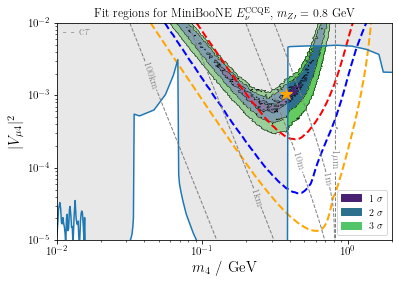

<Figure size 432x288 with 0 Axes>

In [57]:
icarus_factor = (47./60.)**2

m4_in_MeV, UmuNSQR = np.load("Umu4_inv.npy")
m4_lim = m4_in_MeV/1000.
UmuNSQR = np.sqrt(UmuNSQR)

data_enu = data_enu[data_enu.chi2>0]

X = data_enu.m4.values
Y = data_enu.v_mu4.values
Y = Y * Y * coup_factor
Z = (data_enu.chi2.values - chi2_min_enu)
W = data_enu.decay_length.values

X2 = data_enu_sbn.m4.values
Y2 = vmu4_f(data_enu_sbn.u_mu4.values)
Y2 = Y2 * Y2 * coup_factor
Z_mub = data_enu_sbn.n_muB.values
Z_icarus = data_enu_sbn.n_icarus.values * icarus_factor
Z_sbnd = data_enu_sbn.n_sbnd.values

mask_lim = (UmuNSQR < 1./np.sqrt(2))
m4_lim = m4_lim[mask_lim]
UmuNSQR = UmuNSQR[mask_lim]
vmu4_lim = vmu4_f(UmuNSQR) * vmu4_f(UmuNSQR) * coup_factor


xlabel = r'$m_4 \ /$ GeV'
ylabel = r'$|V_{\mu 4}|^2$'
marker1 = '*'

plt.rcParams["figure.figsize"] = (6,4)

cs = plt.tricontourf(X,Y,Z,levels=levels,cmap='viridis')
cs2 = plt.tricontour(X,Y,Z,levels=levels,colors='black',linewidths=0.5)
cs3 = plt.tricontour(X2,Y2,Z_mub,levels=[1000],colors='red',linewidths=2.0, linestyles='dashed')
cs4 = plt.tricontour(X2,Y2,Z_icarus,levels=[1000],colors='blue',linewidths=2.0, linestyles='dashed')
cs5 = plt.tricontour(X2,Y2,Z_sbnd,levels=[1000],colors='orange',linewidths=2.0, linestyles='dashed')

for c in cs.collections:
    c.set_rasterized(True)
for c in cs2.collections:
    c.set_rasterized(True)
for c in cs3.collections:
    c.set_rasterized(True)
for c in cs4.collections:
    c.set_rasterized(True)
for c in cs5.collections:
    c.set_rasterized(True)

limits = plt.plot(m4_lim, vmu4_lim, label=fr"model-independent limits")
plt.fill_between(m4_lim, vmu4_lim, np.ones(np.size(m4_lim))*coup_factor, fc='lightgrey', ec='None', lw =0.0, alpha=0.5)

dec_levels_0 = [0.0001,0.001,0.1,1,100,1000,100000,10000000]
dict_lev_0 = {0.0001: r'1$\mu$m',0.001: r'10$\mu$m',0.1:r'1mm',1: r'1cm',100: r'1m',1000: r'10m',100000:r'1km',10000000:r'100km'}

dec_levels = [0.0001,100,1000,100000,10000000]
dict_lev = {0.0001: r'1$\mu$m',100: r'1m',1000: r'10m',100000:r'1km',10000000:r'100km'}

pos = 5
posb = 1
posc = 1
decay = plt.tricontour(X,Y,W,levels=[dec_levels[0]],colors='gray',linewidths=1.0,linestyles='dashed')
decay2 = plt.tricontour(X,Y,W,levels=[dec_levels[1]],colors='gray',linewidths=1.0,linestyles='dashed')
decay3 = plt.tricontour(X,Y,W,levels=[dec_levels[2]],colors='gray',linewidths=1.0,linestyles='dashed')
decay4 = plt.tricontour(X,Y,W,levels=[dec_levels[3]],colors='gray',linewidths=1.0,linestyles='dashed')
decay5 = plt.tricontour(X,Y,W,levels=[dec_levels[4]],colors='gray',linewidths=1.0,linestyles='dashed')

plt.text(0.011, 70, r'- - c$\tau$', color='gray',fontsize=12,ma='left')

plt.plot(xmin_enu,ymin_enu,color='orange',marker=marker1,markersize=12)
plt.legend(handles=[bar_1, bar_2, bar_3],fontsize=10,loc='lower right')
plt.title(r'Fit regions for MiniBooNE $E_\nu^{\mathrm{CCQE}}$, ' + r'$m_{Z\prime} =$ ' + fr'{mzprime} GeV',fontsize=12)
plt.xlabel(xlabel,fontsize=15)
plt.ylabel(ylabel,fontsize=15)
plt.xscale('log')
plt.yscale('log')

positions = [(0.82,1.3),(0.7,0.7),(0.3,1.0),(0.25,0.4),(0.05,20)]
plt.clabel(decay, decay.levels, inline=True, inline_spacing=-3,manual=[positions[0]], use_clabeltext=True,fmt=dict_lev, fontsize=10)
plt.clabel(decay2, decay2.levels, inline=True, inline_spacing=-3,manual=[positions[1]], use_clabeltext=True,fmt=dict_lev, fontsize=10)
plt.clabel(decay3, decay3.levels, inline=True, inline_spacing=-3,manual=[positions[2]], use_clabeltext=True,fmt=dict_lev, fontsize=10)
plt.clabel(decay4, decay4.levels, inline=True, inline_spacing=-4,manual=[positions[3]], use_clabeltext=True,fmt=dict_lev, fontsize=10)
plt.clabel(decay5, decay5.levels, inline=True, inline_spacing=-6,manual=[positions[4]], use_clabeltext=True,fmt=dict_lev, fontsize=10)

plt.xlim(X.min(),X.max()*1.)
#plt.ylim(Y.min(),Y.max())
plt.ylim(1e-1,Y.max())
yt = 10.**np.arange(-1,3)
yl = [r'$10^{-5}$',r'$10^{-4}$',r'$10^{-3}$',r'$10^{-2}$']
plt.yticks(ticks=yt,labels=yl)

plt.savefig(plot_path_jpg,dpi=400)
#plt.savefig(plot_path_pdf,dpi=400)
plt.show()
plt.clf()

### Enu, $m_{Z'}$ = 200 MeV

In [58]:
mzcase = 1
mzprime = mzprimearray[mzcase]

coup_factor = 1e6

data_enu = pd.read_csv(path_data,sep='\t')
data_enu = data_enu[data_enu.mzprime == mzprime]

data_enu_sbn = pd.read_csv(path_data_sbn,sep='\t')
data_enu_sbn = data_enu_sbn[(data_enu_sbn.mzprime == mzprime)]

plot_path_jpg = path +f'plots/fit_3p1_couplings_mz_{mzprime}_sbn.jpg'
plot_path_pdf = path +f'plots/fit_3p1_couplings_mz_{mzprime}_sbn.pdf'

viridis = cm.get_cmap('viridis', 12)
bar_1 = mpatches.Patch(color=viridis(range(12))[1], label=r'1 $\sigma$')
bar_2 = mpatches.Patch(color=viridis(range(12))[4], label=r'2 $\sigma$')
bar_3 = mpatches.Patch(color=viridis(range(12))[8], label=r'3 $\sigma$')

levels = [0,2.3,6.18,11.83]
chi2_min_enu = data_enu.chi2.min()
min_enu = data_enu[data_enu.chi2 == chi2_min_enu]
xmin_enu, ymin_enu = min_enu['m4'].values, min_enu['v_mu4'].values
ymin_enu *= ymin_enu * coup_factor

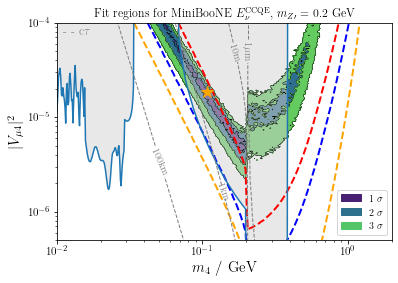

<Figure size 432x288 with 0 Axes>

In [73]:
icarus_factor = (47./60.)**2

m4_in_MeV, UmuNSQR = np.load("Umu4_inv.npy")
m4_lim = m4_in_MeV/1000.
UmuNSQR = np.sqrt(UmuNSQR)

data_enu = data_enu[data_enu.chi2>0]

X = data_enu.m4.values
Y = data_enu.v_mu4.values
Y = Y * Y * coup_factor
Z = (data_enu.chi2.values - chi2_min_enu)
W = data_enu.decay_length.values

X2 = data_enu_sbn.m4.values
Y2 = vmu4_f(data_enu_sbn.u_mu4.values)
Y2 = Y2 * Y2 * coup_factor
Z_mub = data_enu_sbn.n_muB.values
Z_icarus = data_enu_sbn.n_icarus.values * icarus_factor
Z_sbnd = data_enu_sbn.n_sbnd.values

mask_lim = (UmuNSQR < 1./np.sqrt(2))
m4_lim = m4_lim[mask_lim]
UmuNSQR = UmuNSQR[mask_lim]
vmu4_lim = vmu4_f(UmuNSQR) * vmu4_f(UmuNSQR) * coup_factor

xlabel = r'$m_4 \ /$ GeV'
ylabel = r'$|V_{\mu 4}|^2$'
marker1 = '*'

plt.rcParams["figure.figsize"] = (6,4)

cs = plt.tricontourf(X,Y,Z,levels=levels,cmap='viridis')
cs2 = plt.tricontour(X,Y,Z,levels=levels,colors='black',linewidths=0.5)
cs3 = plt.tricontour(X2,Y2,Z_mub,levels=[1000],colors='red',linewidths=2.0, linestyles='dashed')
cs4 = plt.tricontour(X2,Y2,Z_icarus,levels=[1000],colors='blue',linewidths=2.0, linestyles='dashed')
cs5 = plt.tricontour(X2,Y2,Z_sbnd,levels=[1000],colors='orange',linewidths=2.0, linestyles='dashed')

for c in cs.collections:
    c.set_rasterized(True)
for c in cs2.collections:
    c.set_rasterized(True)
for c in cs3.collections:
    c.set_rasterized(True)
for c in cs4.collections:
    c.set_rasterized(True)
for c in cs5.collections:
    c.set_rasterized(True)

limits = plt.plot(m4_lim, vmu4_lim, label=fr"model-independent limits")
plt.fill_between(m4_lim, vmu4_lim, np.ones(np.size(m4_lim))*coup_factor, fc='lightgrey', ec='None', lw =0.0, alpha=0.5)

dec_levels_0 = [0.0001,0.001,0.1,1,100,1000,100000,10000000]
dict_lev_0 = {0.0001: r'1$\mu$m',0.001: r'10$\mu$m',0.1:r'1mm',1: r'1cm',100: r'1m',1000: r'10m',100000:r'1km',10000000:r'100km'}

dec_levels = [0.0001,1000,100000,10000000]
dict_lev = {0.0001: r'1$\mu$m',1000: r'10m',100000:r'1km',10000000:r'100km'}


dec_levels_b = [1e-1,1,1000,100000,10000000]
dict_lev_b = {1e-1:r'1mm',1: r'1cm',1000: r'10m',100000:r'1km',10000000:r'100km'}

test = 1e-1
#dec_levels_b = [test]
#dict_lev_b = {test: r'test'}
testc = 1e-2
#dec_levels_c = [testc]
#dict_lev_c = {testc: r'0.1mm'}
dict_lev_d = {testc: r'    '}


pos = 4
decay = plt.tricontour(X,Y,W,levels=[dec_levels[0]],colors='gray',linewidths=1.0,linestyles='dashed')
decay2 = plt.tricontour(X,Y,W,levels=[dec_levels[1]],colors='gray',linewidths=1.0,linestyles='dashed')
decay3 = plt.tricontour(X,Y,W,levels=[dec_levels[2]],colors='gray',linewidths=1.0,linestyles='dashed')
decay4 = plt.tricontour(X,Y,W,levels=[dec_levels[3]],colors='gray',linewidths=1.0,linestyles='dashed')

plt.text(0.011, 75, r'- - c$\tau$', color='gray',fontsize=12,ma='left')

plt.plot(xmin_enu,ymin_enu,color='orange',marker=marker1,markersize=12)
plt.legend(handles=[bar_1, bar_2, bar_3],fontsize=10,loc='lower right')
plt.title(r'Fit regions for MiniBooNE $E_\nu^{\mathrm{CCQE}}$, ' + r'$m_{Z\prime} =$ ' + fr'{mzprime} GeV',fontsize=12)
plt.xlabel(xlabel,fontsize=15)
plt.ylabel(ylabel,fontsize=15)
plt.xscale('log')
plt.yscale('log')

positions = [(0.2,50),(0.13,40),(0.11,1.3),(0.045,3)]
plt.clabel(decay, decay.levels, inline=True, inline_spacing=-6,manual=[positions[0]], use_clabeltext=True,fmt=dict_lev, fontsize=10)
plt.clabel(decay2, decay2.levels, inline=True, inline_spacing=-6,manual=[positions[1]], use_clabeltext=True,fmt=dict_lev, fontsize=10)
plt.clabel(decay3, decay3.levels, inline=True, inline_spacing=-7,manual=[positions[2]], use_clabeltext=True,fmt=dict_lev, fontsize=10)
plt.clabel(decay4, decay4.levels, inline=True, inline_spacing=-9,manual=[positions[3]], use_clabeltext=True,fmt=dict_lev, fontsize=10)

plt.xlim(X.min(),X.max()*1.)
#plt.ylim(Y.min(),Y.max())
plt.ylim(5e-1,Y.max())
yt = 10.**np.arange(0,3)
yl = [r'$10^{-6}$',r'$10^{-5}$',r'$10^{-4}$']
plt.yticks(ticks=yt,labels=yl)

#plt.savefig(plot_path_jpg,dpi=400)
plt.savefig(plot_path_pdf,dpi=400)
plt.show()
plt.clf()

### Enu, $m_{Z'}$ = 30 MeV

In [74]:
mzcase = 0
mzprime = mzprimearray[mzcase]

coup_factor = 1e8

data_enu = pd.read_csv(path_data,sep='\t')
data_enu = data_enu[data_enu.mzprime == mzprime]

data_enu_sbn = pd.read_csv(path_data_sbn,sep='\t')
data_enu_sbn = data_enu_sbn[(data_enu_sbn.mzprime == mzprime)]

plot_path_jpg = path +f'plots/fit_3p1_couplings_mz_{mzprime}_sbn.jpg'
plot_path_pdf = path +f'plots/fit_3p1_couplings_mz_{mzprime}_sbn.pdf'

viridis = cm.get_cmap('viridis', 12)
bar_1 = mpatches.Patch(color=viridis(range(12))[1], label=r'1 $\sigma$')
bar_2 = mpatches.Patch(color=viridis(range(12))[4], label=r'2 $\sigma$')
bar_3 = mpatches.Patch(color=viridis(range(12))[8], label=r'3 $\sigma$')

levels = [0,2.3,6.18,11.83]
chi2_min_enu = data_enu.chi2.min()
min_enu = data_enu[data_enu.chi2 == chi2_min_enu]
xmin_enu, ymin_enu = min_enu['m4'].values, min_enu['v_mu4'].values
ymin_enu *= ymin_enu * coup_factor

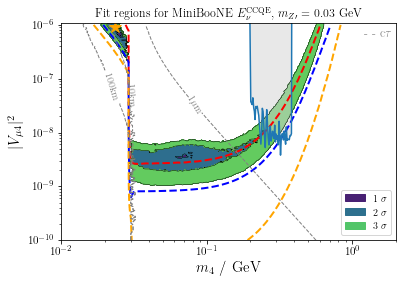

<Figure size 432x288 with 0 Axes>

In [88]:
icarus_factor = (47./60.)**2

m4_in_MeV, UmuNSQR = np.load("Umu4_inv.npy")
m4_lim = m4_in_MeV/1000.
UmuNSQR = np.sqrt(UmuNSQR)

data_enu = data_enu[data_enu.chi2>0]

Y = data_enu.v_mu4.values
Y = Y * Y * coup_factor
masky = Y <= 1000
X = data_enu.m4.values
Z = (data_enu.chi2.values - chi2_min_enu)
W = data_enu.decay_length.values


X2 = data_enu_sbn.m4.values
Y2 = vmu4_f(data_enu_sbn.u_mu4.values)
Y2 = Y2 * Y2 * coup_factor
Z_mub = data_enu_sbn.n_muB.values
Z_icarus = data_enu_sbn.n_icarus.values * icarus_factor
Z_sbnd = data_enu_sbn.n_sbnd.values

mask_lim = (UmuNSQR < 1./np.sqrt(2))
m4_lim = m4_lim[mask_lim]
UmuNSQR = UmuNSQR[mask_lim]
vmu4_lim = vmu4_f(UmuNSQR) * vmu4_f(UmuNSQR) * coup_factor

xlabel = r'$m_4 \ /$ GeV'
ylabel = r'$|V_{\mu 4}|^2$'
marker1 = '*'

plt.rcParams["figure.figsize"] = (6,4)

cs = plt.tricontourf(X,Y,Z,levels=levels,cmap='viridis')
cs2 = plt.tricontour(X,Y,Z,levels=levels,colors='black',linewidths=0.5)
cs3 = plt.tricontour(X2,Y2,Z_mub,levels=[1000],colors='red',linewidths=2.0, linestyles='dashed')
cs4 = plt.tricontour(X2,Y2,Z_icarus,levels=[1000],colors='blue',linewidths=2.0, linestyles='dashed')
cs5 = plt.tricontour(X2,Y2,Z_sbnd,levels=[1000],colors='orange',linewidths=2.0, linestyles='dashed')

for c in cs.collections:
    c.set_rasterized(True)
for c in cs2.collections:
    c.set_rasterized(True)
for c in cs3.collections:
    c.set_rasterized(True)
for c in cs4.collections:
    c.set_rasterized(True)
for c in cs5.collections:
    c.set_rasterized(True)

limits = plt.plot(m4_lim, vmu4_lim, label=fr"model-independent limits")
plt.fill_between(m4_lim, vmu4_lim, np.ones(np.size(m4_lim))*coup_factor, fc='lightgrey', ec='None', lw =0.0, alpha=0.5)

dec_levels_0 = [0.0001,0.001,0.1,1,100,1000,100000,10000000]
dict_lev_0 = {0.0001: r'1$\mu$m',0.001: r'10$\mu$m',0.1:r'1mm',1: r'1cm',100: r'1m',1000: r'10m',100000:r'1km',10000000:r'100km'}


dec_levels = [0.0001,1000000,10000000]
dict_lev = {0.0001: r'1$\mu$m',10000000:r'100km',1000000:r'10km'}


dec_levels_b = [1e-1,1,1000,100000,10000000]
dict_lev_b = {1e-1:r'1mm',1: r'1cm',1000: r'10m',100000:r'1km',10000000:r'100km'}

test = 1e-1
#dec_levels_b = [test]
#dict_lev_b = {test: r'test'}
testc = 1e-2
#dec_levels_c = [testc]
#dict_lev_c = {testc: r'0.1mm'}
dict_lev_d = {testc: r'    '}


pos = 3
decay = plt.tricontour(X[masky],Y[masky],W[masky],levels=[dec_levels[0]],colors='gray',linewidths=1.0,linestyles='dashed')
decay2 = plt.tricontour(X,Y,W,levels=[dec_levels[1]],colors='gray',linewidths=1.0,linestyles='dashed')
decay3 = plt.tricontour(X,Y,W,levels=[dec_levels[2]],colors='gray',linewidths=1.0,linestyles='dashed')

plt.text(1.2, 60, r'- - c$\tau$', color='gray',fontsize=12,ma='left')

plt.plot(xmin_enu,ymin_enu,color='orange',marker=marker1,markersize=12)
plt.legend(handles=[bar_1, bar_2, bar_3],fontsize=10,loc='lower right')
plt.title(r'Fit regions for MiniBooNE $E_\nu^{\mathrm{CCQE}}$, ' + r'$m_{Z\prime} =$ ' + fr'{mzprime} GeV',fontsize=12)
plt.xlabel(xlabel,fontsize=15)
plt.ylabel(ylabel,fontsize=15)
plt.xscale('log')
plt.yscale('log')

positions = [(0.1,4),(0.03,5),(0.02,7)]
plt.clabel(decay, decay.levels, inline=True, inline_spacing=-4,manual=[positions[0]], use_clabeltext=True,fmt=dict_lev, fontsize=10)
plt.clabel(decay2, decay2.levels, inline=True, inline_spacing=-4,manual=[positions[1]], use_clabeltext=True,fmt=dict_lev, fontsize=10)
plt.clabel(decay3, decay3.levels, inline=True, inline_spacing=-3,manual=[positions[2]], use_clabeltext=True,fmt=dict_lev, fontsize=10)

plt.xlim(X.min(),X.max()*1.)
#plt.ylim(Y.min(),Y.max())
plt.ylim(Y.min(),1.1e2)
#plt.ylim(1e-2,Y.max())
yt = 10.**np.arange(-2,3)
yl = [r'$10^{-10}$',r'$10^{-9}$',r'$10^{-8}$',r'$10^{-7}$',r'$10^{-6}$']
plt.yticks(ticks=yt,labels=yl)

plt.savefig(plot_path_jpg,dpi=400)
#plt.savefig(plot_path_pdf,dpi=400)
plt.show()
plt.clf()